# Advanced Regularization in LiVAE

This tutorial demonstrates how different regularization techniques affect learned embeddings. We'll compare four configurations on hierarchical data that mimics cell differentiation.

## 1. Setup and Data Preparation

We create synthetic data with **hierarchical structure** representing biological lineages:
- **Lineage A** (180 cells): Two subtypes (A1: 100 cells, A2: 80 cells)
- **Lineage B** (220 cells): Three subtypes (B1: 90 cells, B2: 70 cells, B3: 60 cells)
- **150 genes** total with shared lineage markers and subtype-specific markers

**Gene expression design:**
- Genes 0-25: Lineage A markers (shared by A1 and A2)
- Genes 25-40: A1-specific markers
- Genes 40-55: A2-specific markers
- Genes 60-80: Lineage B markers (shared by B1, B2, B3)
- Genes 80-90: B1-specific markers
- Genes 90-100: B2-specific markers
- Genes 100-110: B3-specific markers
- Background: Poisson(λ=4.0) baseline expression
- Markers: Poisson(λ=15-20) high expression in relevant regions

This hierarchical structure tests how well each model captures multi-level relationships.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from livae import agent
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

np.random.seed(42)

# Create synthetic data with hierarchical cell differentiation structure
def create_hierarchical_data():
    """
    Generate synthetic single-cell data mimicking hierarchical differentiation:
    
    Lineage A (180 cells):
      ├─ Subtype A1 (100 cells): Shares A markers + A1-specific markers
      └─ Subtype A2 (80 cells): Shares A markers + A2-specific markers
    
    Lineage B (220 cells):
      ├─ Subtype B1 (90 cells): Shares B markers + B1-specific markers
      ├─ Subtype B2 (70 cells): Shares B markers + B2-specific markers
      └─ Subtype B3 (60 cells): Shares B markers + B3-specific markers
    
    Expression strategy:
    - Background: Poisson(λ=4.0) across all 150 genes
    - Lineage markers: Poisson(λ=20.0) in shared regions (5× higher)
    - Subtype markers: Poisson(λ=15.0) in specific regions (3.75× higher)
    """
    n_genes = 150
    
    # === Lineage A ===
    # A1: Shares genes 0-25 with A2, plus specific genes 25-40
    data_A1 = np.random.poisson(4.0, (100, n_genes))
    data_A1[:, :25] = np.random.poisson(20.0, (100, 25))   # Lineage A markers
    data_A1[:, 25:40] = np.random.poisson(15.0, (100, 15))  # A1-specific
    
    # A2: Shares genes 0-25 with A1, plus specific genes 40-55
    data_A2 = np.random.poisson(4.0, (80, n_genes))
    data_A2[:, :25] = np.random.poisson(20.0, (80, 25))    # Lineage A markers
    data_A2[:, 40:55] = np.random.poisson(15.0, (80, 15))  # A2-specific
    
    # === Lineage B ===
    # B1: Shares genes 60-80 with other B subtypes, plus specific genes 80-90
    data_B1 = np.random.poisson(4.0, (90, n_genes))
    data_B1[:, 60:80] = np.random.poisson(20.0, (90, 20))  # Lineage B markers
    data_B1[:, 80:90] = np.random.poisson(15.0, (90, 10))  # B1-specific
    
    # B2: Shares genes 60-80, plus specific genes 90-100
    data_B2 = np.random.poisson(4.0, (70, n_genes))
    data_B2[:, 60:80] = np.random.poisson(20.0, (70, 20))  # Lineage B markers
    data_B2[:, 90:100] = np.random.poisson(15.0, (70, 10))  # B2-specific
    
    # B3: Shares genes 60-80, plus specific genes 100-110
    data_B3 = np.random.poisson(4.0, (60, n_genes))
    data_B3[:, 60:80] = np.random.poisson(20.0, (60, 20))  # Lineage B markers
    data_B3[:, 100:110] = np.random.poisson(15.0, (60, 10))  # B3-specific
    
    # Combine all cell types
    X = np.vstack([data_A1, data_A2, data_B1, data_B2, data_B3]).astype(float)
    
    # Create hierarchical labels
    lineage = ['A']*180 + ['B']*220
    subtype = ['A1']*100 + ['A2']*80 + ['B1']*90 + ['B2']*70 + ['B3']*60
    
    # Build AnnData object
    adata = ad.AnnData(X)
    adata.obs['lineage'] = lineage
    adata.obs['subtype'] = subtype
    adata.layers['counts'] = X.copy()
    adata.var_names = [f'Gene_{i}' for i in range(n_genes)]
    
    return adata

adata = create_hierarchical_data()

print(f"Created hierarchical dataset:")
print(f"  Shape: {adata.shape}")
print(f"  Lineages: {adata.obs['lineage'].value_counts().to_dict()}")
print(f"  Subtypes: {adata.obs['subtype'].value_counts().to_dict()}")

Created hierarchical dataset:
  Shape: (400, 150)
  Lineages: {'B': 220, 'A': 180}
  Subtypes: {'A1': 100, 'B1': 90, 'A2': 80, 'B2': 70, 'B3': 60}


## 2. Baseline Model (Standard VAE)

**Configuration:** `beta=1.0` (no additional regularization)

This serves as our reference point - a standard Variational Autoencoder without specialized regularization. The baseline uses:
- Standard KL divergence weight (β=1.0)
- No hyperbolic geometry constraints
- No interpretable embedding enforcement

Training on 1000 epochs to ensure convergence. Baseline performance will help us quantify the benefits of each regularization technique.

In [2]:
# Train baseline model: Standard VAE without additional regularization
print("Training baseline model (beta=1.0, no additional regularization)...\n")

model_baseline = agent(
    adata=adata,
    layer='counts',
    latent_dim=10,
    hidden_dim=64,
    percent=0.15,          # Batch size: 15% of 400 cells = 60 cells
    lr=1e-3,
    beta=1.0,              # Standard VAE (balanced KL divergence)
)

model_baseline.fit(epochs=1000)

# Extract both embedding types
latent_baseline = model_baseline.get_latent()
iembed_baseline = model_baseline.get_iembed()

print("\n✅ Baseline model trained")

Training baseline model (beta=1.0, no additional regularization)...



Fitting: 100%|███████████████████████████| 1000/1000 [00:13<00:00, 72.49it/s, Loss=246.00, ARI=0.07, NMI=0.33, ASW=0.07, C_H=4.50, D_B=1.82, P_C=0.98]


✅ Baseline model trained


## 3. β-VAE: Controlled Entanglement

**Configuration:** `beta=1e-2` (lower β = 0.01)

**β-VAE theory:**
- Standard VAE: β = 1.0 (balance reconstruction vs. KL divergence)
- β > 1.0: Encourages **disentanglement** (independent latent factors)
- β < 1.0: Allows **entanglement** (dependent latent factors)

**Why use β = 0.01?**
For biological data, lower β values are often beneficial because:
- Biological processes are inherently entangled (genes work in pathways)
- Cell types exist on continuous spectra, not discrete categories
- Lower reconstruction penalty preserves more biological signal

This configuration prioritizes reconstruction quality while allowing the model to learn natural dependencies between latent dimensions.

In [3]:
# Train β-VAE: Lower β encourages entangled representations
print("Training β-VAE model (beta=1e-2)...\n")

model_beta = agent(
    adata=adata,
    layer='counts',
    latent_dim=10,
    hidden_dim=64,
    percent=0.15,          # Batch size: 60 cells
    lr=1e-3,
    beta=1e-2,             # Low β (0.01) allows entanglement
)

model_beta.fit(epochs=1000)

latent_beta = model_beta.get_latent()
iembed_beta = model_beta.get_iembed()

print("\n✅ β-VAE model trained")
print("\nβ-VAE Effect: Lower β → More entangled latent factors")
print("  β = 1.0: Standard VAE (independent factors)")
print("  β = 0.01: Allows dependencies between latent dimensions")

Training β-VAE model (beta=1e-2)...



Fitting: 100%|██████████████████████████| 1000/1000 [00:14<00:00, 71.32it/s, Loss=241.06, ARI=0.61, NMI=0.73, ASW=0.20, C_H=23.16, D_B=1.54, P_C=2.45]


✅ β-VAE model trained

β-VAE Effect: Lower β → More entangled latent factors
  β = 1.0: Standard VAE (independent factors)
  β = 0.01: Allows dependencies between latent dimensions


## 4. Lorentzian Regularization: Hyperbolic Geometry

**Configuration:** `beta=1.0, lorentz=5.0, i_dim=2, irecon=1.0`

**Hyperbolic space motivation:**
Traditional VAEs embed data in Euclidean space, but hyperbolic geometry is better suited for:
- **Hierarchical relationships** (tree-like structures)
- **Exponentially growing branching** (cell differentiation)
- **Scale-free networks** (biological regulatory networks)

**Parameter explanation:**
- `lorentz=5.0`: Strength of Lorentzian/hyperbolic constraint (moderate strength)
- `i_dim=2`: Interpretable embedding dimension (2D for visualization)
- `irecon=1.0`: Weight for interpretable reconstruction loss

**Expected behavior:**
The model learns embeddings where distance naturally reflects hierarchical relationships. Lineage A and B should form distinct branches, with subtypes clustering within each lineage.

In [4]:
# Train Lorentzian model: Hyperbolic geometry for hierarchical structure
print("Training Lorentzian model (lorentz=5.0)...\n")

model_lorentz = agent(
    adata=adata,
    layer='counts',
    latent_dim=10,
    i_dim=2,               # Enable interpretable 2D embedding
    hidden_dim=64,
    percent=0.15,          # Batch size: 60 cells
    lr=1e-3,
    beta=1.0,              # Standard VAE baseline
    lorentz=5.0,           # Hyperbolic space regularization (moderate strength)
    irecon=1.0,            # Interpretable reconstruction loss
)

model_lorentz.fit(epochs=1000)

latent_lorentz = model_lorentz.get_latent()
iembed_lorentz = model_lorentz.get_iembed()

print("\n✅ Lorentzian model trained")
print("\nLorentzian Effect: Embeds data in hyperbolic space")
print("  Benefit: Captures tree-like hierarchical relationships")
print("  Use case: Cell lineages, differentiation trajectories")

Training Lorentzian model (lorentz=5.0)...



Fitting: 100%|██████████████████████████| 1000/1000 [00:15<00:00, 66.07it/s, Loss=492.91, ARI=0.62, NMI=0.72, ASW=0.15, C_H=11.52, D_B=1.36, P_C=1.79]


✅ Lorentzian model trained

Lorentzian Effect: Embeds data in hyperbolic space
  Benefit: Captures tree-like hierarchical relationships
  Use case: Cell lineages, differentiation trajectories


## 5. Combined Regularization: Full LiVAE

**Configuration:** `beta=1e-2, lorentz=5.0, irecon=1.0`

The full LiVAE model synergistically combines all regularization techniques:

**Multi-objective optimization:**
1. **β-VAE (β=0.01)**: Allows entangled representations that capture biological dependencies
2. **Lorentzian (lorentz=5.0)**: Embeds data in hyperbolic space to respect hierarchical structure
3. **Interpretable reconstruction (irecon=1.0)**: Ensures the compressed 2D embedding retains information

**Synergistic effects:**
- Low β prevents over-regularization while hyperbolic geometry provides structure
- Interpretable embedding is constrained by both reconstruction quality and geometric properties
- The model learns biologically meaningful embeddings that are both accurate and interpretable

This configuration is recommended for complex biological data with hierarchical organization.

In [5]:
# Train full LiVAE: Synergistic combination of all regularizations
print("Training full LiVAE model (beta + lorentz + irecon)...\n")

model_full = agent(
    adata=adata,
    layer='counts',
    latent_dim=10,
    i_dim=2,               # Interpretable 2D embedding
    hidden_dim=64,
    percent=0.15,          # Batch size: 60 cells
    lr=1e-3,
    beta=1e-2,             # Low β for entanglement
    lorentz=5.0,           # Hyperbolic geometry for hierarchy
    irecon=1.0,            # Interpretable reconstruction quality
)

model_full.fit(epochs=1000)
latent_full = model_full.get_latent()
iembed_full = model_full.get_iembed()

print("\n✅ Full LiVAE model trained")
print("\nCombined regularization benefits:")
print("  β-VAE (0.01): Entangled factors for biological dependencies")
print("  Lorentzian (5.0): Hierarchical structure preservation")
print("  irecon (1.0): High-quality interpretable 2D embedding")

Training full LiVAE model (beta + lorentz + irecon)...



Fitting: 100%|█████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s, Loss=494.03, ARI=0.68, NMI=0.77, ASW=0.44, C_H=395.85, D_B=0.76, P_C=6.35]


✅ Full LiVAE model trained

Combined regularization benefits:
  β-VAE (0.01): Entangled factors for biological dependencies
  Lorentzian (5.0): Hierarchical structure preservation
  irecon (1.0): High-quality interpretable 2D embedding


## 6. Comparative Analysis

Now we'll visualize all four models side-by-side to understand how each regularization affects the learned embeddings:

**Visualization strategy:**
- **Top row**: Interpretable 2D embeddings colored by main lineage (A vs B)
- **Bottom row**: Interpretable 2D embeddings colored by subtype (A1, A2, B1, B2, B3)

**What to look for:**
1. **Separation quality**: How well are lineages and subtypes separated?
2. **Geometric structure**: Are hierarchical relationships preserved?
3. **Cluster compactness**: Are subtypes forming tight, coherent clusters?
4. **Interpretability**: Does the embedding match our biological intuition?

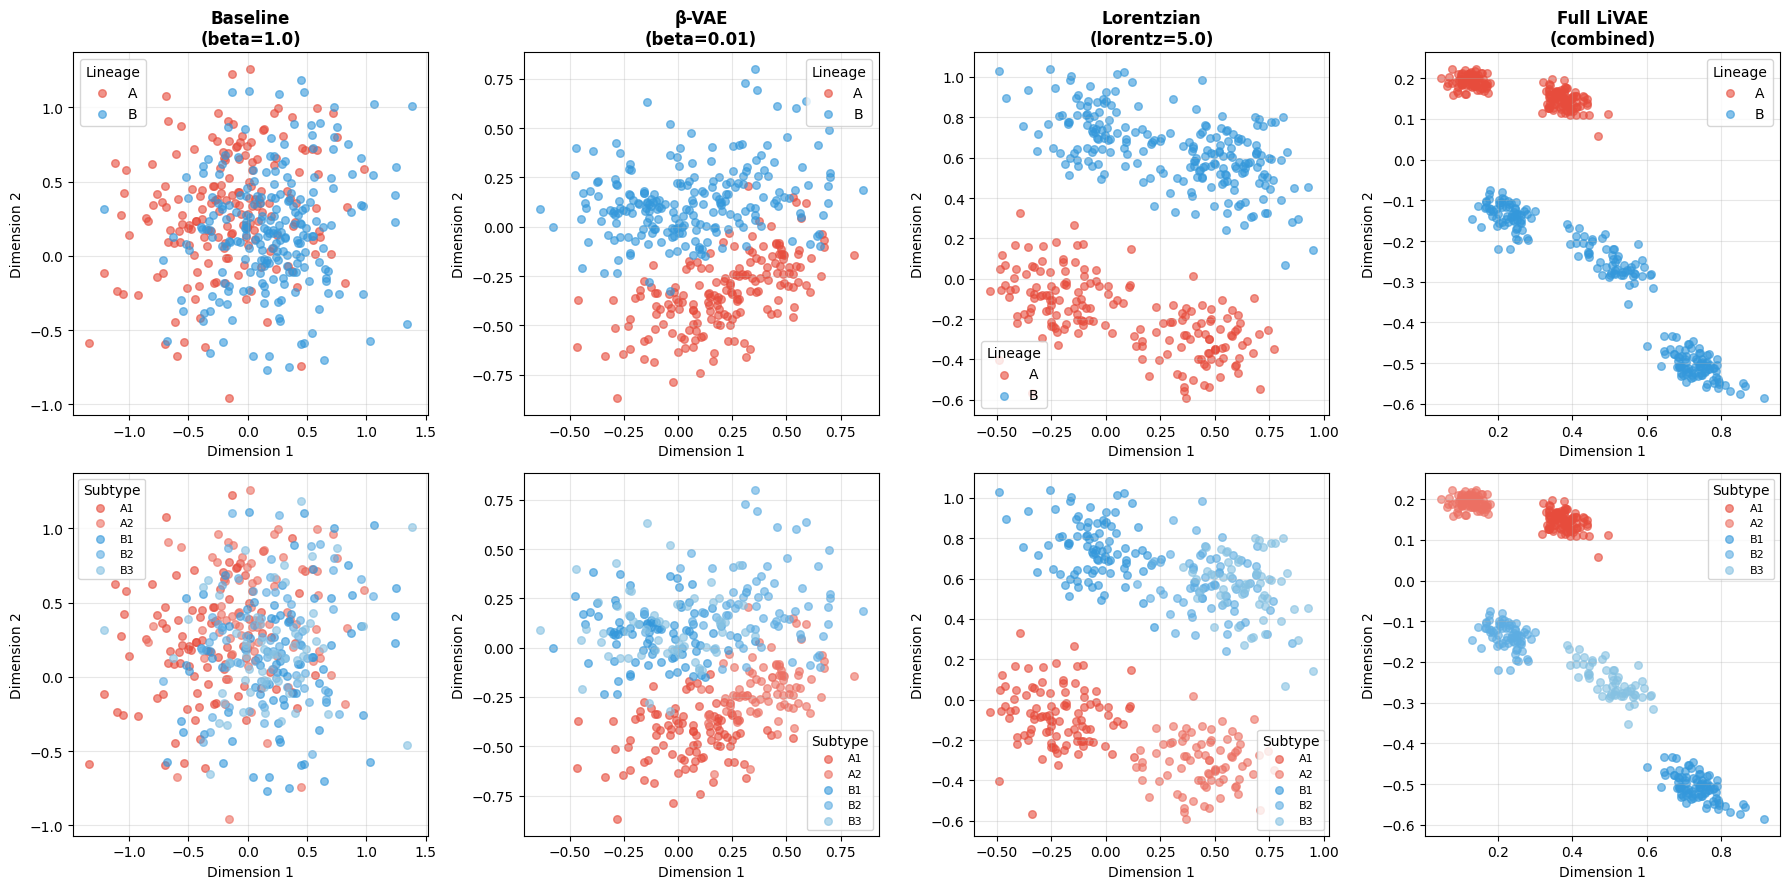

Visualization complete! Compare the separation quality across models.


In [6]:
# Visualize interpretable embeddings from all four models
fig, axes = plt.subplots(2, 4, figsize=(18, 9))

models = [
    ('Baseline\n(beta=1.0)', iembed_baseline, latent_baseline),
    ('β-VAE\n(beta=0.01)', iembed_beta, latent_beta),
    ('Lorentzian\n(lorentz=5.0)', iembed_lorentz, latent_lorentz),
    ('Full LiVAE\n(combined)', iembed_full, latent_full)
]

colors_lineage = {'A': '#E74C3C', 'B': '#3498DB'}  # Red and blue
colors_subtype = {'A1': '#E74C3C', 'A2': '#EC7063', 
                  'B1': '#3498DB', 'B2': '#5DADE2', 'B3': '#85C1E2'}

# Row 1: Color by main lineage (coarse-grained structure)
for i, (title, iembed, latent) in enumerate(models):
    ax = axes[0, i]
    for lineage, color in colors_lineage.items():
        mask = adata.obs['lineage'] == lineage
        ax.scatter(iembed[mask, 0], iembed[mask, 1], 
                  c=color, label=lineage, alpha=0.6, s=30)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend(title='Lineage')
    ax.grid(alpha=0.3)

# Row 2: Color by subtype (fine-grained structure)
for i, (title, iembed, latent) in enumerate(models):
    ax = axes[1, i]
    for subtype, color in colors_subtype.items():
        mask = adata.obs['subtype'] == subtype
        ax.scatter(iembed[mask, 0], iembed[mask, 1], 
                  c=color, label=subtype, alpha=0.6, s=30)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend(title='Subtype', fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization complete! Compare the separation quality across models.")

## 7. Quantitative Comparison

Beyond visual inspection, we compute clustering metrics to objectively compare model performance:

**Metrics computed:**
- **Adjusted Rand Index (ARI)**: Measures agreement with true labels (-1 to 1, higher is better)
- **Normalized Mutual Information (NMI)**: Information-theoretic similarity (0 to 1, higher is better)

**Interpretation guide:**
- ARI/NMI > 0.7: Excellent clustering (strong agreement with ground truth)
- ARI/NMI 0.4-0.7: Good clustering (moderate agreement)
- ARI/NMI < 0.4: Poor clustering (weak agreement)

We'll evaluate against both:
1. **Main lineage** (2 groups: A vs B) - tests coarse-grained structure
2. **Subtypes** (5 groups: A1, A2, B1, B2, B3) - tests fine-grained structure


CLUSTERING PERFORMANCE ON SUBTYPES (5 clusters)
                       ARI       NMI       ASW
Baseline (β=1.0)  0.201616  0.241467  0.023393
β-VAE (β=0.01)    1.000000  1.000000  0.430013
Lorentzian        0.811770  0.820403  0.209178
Full LiVAE        1.000000  1.000000  0.745681

Interpretation:
  • Higher ARI/NMI = Better agreement with ground truth
  • Higher ASW = More compact, well-separated clusters
  • Best model should have highest scores across all metrics


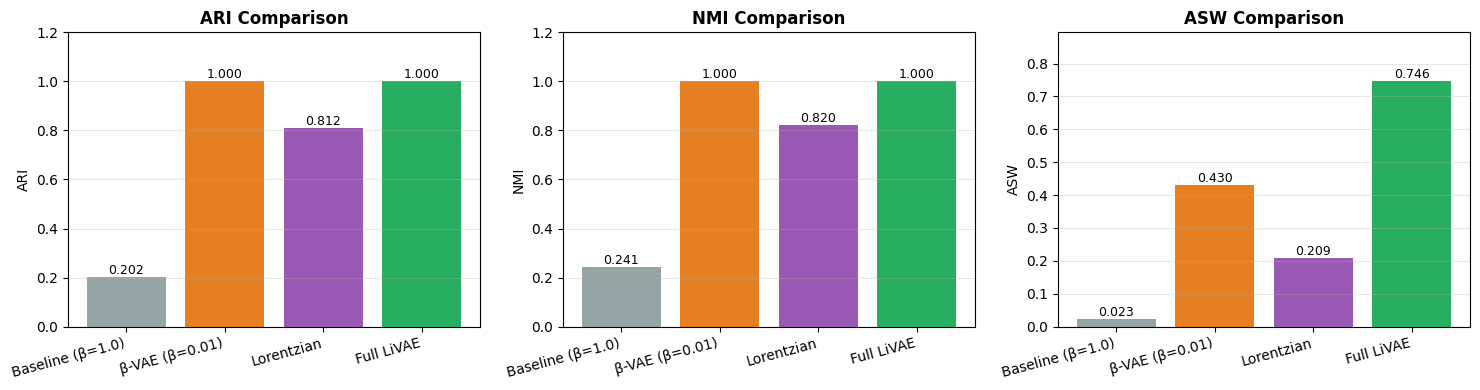

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def evaluate_clustering(latent, true_labels, n_clusters):
    """
    Evaluate clustering quality using multiple metrics.
    
    Args:
        latent: Learned embedding (n_cells × n_dims)
        true_labels: Ground truth labels
        n_clusters: Number of clusters for K-means
    
    Returns:
        Dictionary with ARI, NMI, and ASW scores
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pred_labels = kmeans.fit_predict(latent)
    
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    asw = silhouette_score(latent, true_labels)
    
    return {'ARI': ari, 'NMI': nmi, 'ASW': asw}

# Encode true labels for subtypes (5 clusters)
subtype_map = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'B3': 4}
true_subtype_labels = adata.obs['subtype'].map(subtype_map).values

# Evaluate all four models on subtype clustering
results = {
    'Baseline (β=1.0)': evaluate_clustering(latent_baseline, true_subtype_labels, n_clusters=5),
    'β-VAE (β=0.01)': evaluate_clustering(latent_beta, true_subtype_labels, n_clusters=5),
    'Lorentzian': evaluate_clustering(latent_lorentz, true_subtype_labels, n_clusters=5),
    'Full LiVAE': evaluate_clustering(latent_full, true_subtype_labels, n_clusters=5)
}

# Create results table
df_results = pd.DataFrame(results).T
print("\n" + "="*60)
print("CLUSTERING PERFORMANCE ON SUBTYPES (5 clusters)")
print("="*60)
print(df_results.to_string())
print("\nInterpretation:")
print("  • Higher ARI/NMI = Better agreement with ground truth")
print("  • Higher ASW = More compact, well-separated clusters")
print("  • Best model should have highest scores across all metrics")

# Visualize metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['ARI', 'NMI', 'ASW']
for i, metric in enumerate(metrics):
    ax = axes[i]
    values = df_results[metric].values
    bars = ax.bar(range(len(df_results)), values, 
                  color=['#95A5A6', '#E67E22', '#9B59B6', '#27AE60'])
    ax.set_xticks(range(len(df_results)))
    ax.set_xticklabels(df_results.index, rotation=15, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, max(values) * 1.2])
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{values[j]:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()